###**PLN - Universidad Nacional de Colombia**

##Taller 2
###Representaciones: bow, tfidf, word2vect
###Profesora Elizabeth León Guzmán
---
###David Esteban Casallas Meneses


### Imports


In [86]:
!pip install datasets

In [87]:
!pip install gensim

In [88]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 7.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import random


from datasets import load_dataset
from datasets import Dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import spacy
import gensim

from gensim.models import FastText

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import common_texts
from scipy import spatial

# 1. tfidf

* Escoger y bajar el conjunto de documentos en español

* Cargarlo el data set

In [91]:
ds = load_dataset("MarcOrfilaCarreras/spanish-news") # Cargamos el dataset de noticias en español

In [92]:
df = ds['train'].to_pandas()
display(df['text']) # Nos interesan los textos de las noticias, por ahora no el resto de información

0        Valladolid misteriosa es el título del nuevo l...
1        El coraje de ser, de Mónica Cavallé, la aventu...
2        En la Tercera el francés, de Federico Supervie...
3        No fue Un fuego azul la primera novela de Pedr...
4        El tropiezo del tiempo, de Eduardo Álvarez Tuñ...
                               ...                        
10195    Pamplona, 14 feb (.).- El sindicato LAB ha rec...
10196    El lunes, Argus subió el precio objetivo de Ph...
10197    Investing.com - Con el sorpresivo dato de la i...
10198    El lunes, Gimme Credit, una firma de análisis ...
10199    Por Scott DiSavinoNUEVA YORK, 12 feb (Reuters)...
Name: text, Length: 10200, dtype: object

In [93]:
documentos = df['text'][0:10] # Por ahora vamos a considerar 10 de los documentos
documentos

0    Valladolid misteriosa es el título del nuevo l...
1    El coraje de ser, de Mónica Cavallé, la aventu...
2    En la Tercera el francés, de Federico Supervie...
3    No fue Un fuego azul la primera novela de Pedr...
4    El tropiezo del tiempo, de Eduardo Álvarez Tuñ...
5    Cómo aplicar el método del plato, de Adriana O...
6    La periodista Núria Marín presenta su primera ...
7    Alas de hierro, de Rebecca Yarros, la segunda ...
8    El año de la coronación, la última novela de m...
9    Los tres terribles inventos de Walter Swizwit,...
Name: text, dtype: object

## Construir la matriz tf, tf_idf, y trigramas por palabras

In [94]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('spanish') # Cargamos las stop words del español

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
def normalize_document(texto):
    # 1. Convertir a minúsculas
    texto = texto.lower()

    # 2. Remover caracteres especiales (excepto letras con tilde)
    texto_limpio = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]", "", texto)

    # 3. Tokenizar el texto usando nltk
    tokens = nltk.word_tokenize(texto_limpio, language="spanish")

    # 4. Remover stop words del español
    filtered_tokens = [token for token in tokens if token not in stop_words]

    doc = ' '.join(filtered_tokens)

    return doc

normalize_corpus = np.vectorize(normalize_document)

In [96]:
# Ejemplo de uso
documento = documentos[0]
tokens = normalize_document(documento)
print(tokens)

valladolid misteriosa título nuevo libro acaba publicar editorial almuzara trata obra investigador paranormal juan carlos pasalodos pérez realiza exhaustiva recopilación gran parte enigmas relatos legendarios vinculados historia valladolidy capital caracteriza rica historia ende abundancia leyendas arcanos autor recoge volumen junto serie casos asombrosos ocurridos misma urbe provincia relacionados fenómenos inexplicables parecen esquivos comprensión humanaasí páginas libro podremos encontrar relatos paranormal coincidencias inverosímiles testimonios sorprendentes avistamientos exorcismos sucesos desafían toda explicación lógica misterios sábana santa vallisoletana capilla don alonso castillaen definitiva valladolid misteriosa libro aparte satisfacer curiosidad aquellos desean explorar enigmas rodean legendaria ciudad narra hechos experiencias ahora nadie atrevido publicar enriqueciendo alguna forma bibliografía editada temajuan carlos pasalodos pérez valladolid investigador misterios 

In [97]:
norm_corpus = normalize_corpus(documentos)
norm_corpus

array(['valladolid misteriosa título nuevo libro acaba publicar editorial almuzara trata obra investigador paranormal juan carlos pasalodos pérez realiza exhaustiva recopilación gran parte enigmas relatos legendarios vinculados historia valladolidy capital caracteriza rica historia ende abundancia leyendas arcanos autor recoge volumen junto serie casos asombrosos ocurridos misma urbe provincia relacionados fenómenos inexplicables parecen esquivos comprensión humanaasí páginas libro podremos encontrar relatos paranormal coincidencias inverosímiles testimonios sorprendentes avistamientos exorcismos sucesos desafían toda explicación lógica misterios sábana santa vallisoletana capilla don alonso castillaen definitiva valladolid misteriosa libro aparte satisfacer curiosidad aquellos desean explorar enigmas rodean legendaria ciudad narra hechos experiencias ahora nadie atrevido publicar enriqueciendo alguna forma bibliografía editada temajuan carlos pasalodos pérez valladolid investigador mi

### Matríz TF

In [98]:
vocab = {}
i = 0

for doc in norm_corpus:
  for word in doc.split():
    if word in vocab:
        continue
    else:
        vocab[word]=i
        i+=1

print(vocab)

{'valladolid': 0, 'misteriosa': 1, 'título': 2, 'nuevo': 3, 'libro': 4, 'acaba': 5, 'publicar': 6, 'editorial': 7, 'almuzara': 8, 'trata': 9, 'obra': 10, 'investigador': 11, 'paranormal': 12, 'juan': 13, 'carlos': 14, 'pasalodos': 15, 'pérez': 16, 'realiza': 17, 'exhaustiva': 18, 'recopilación': 19, 'gran': 20, 'parte': 21, 'enigmas': 22, 'relatos': 23, 'legendarios': 24, 'vinculados': 25, 'historia': 26, 'valladolidy': 27, 'capital': 28, 'caracteriza': 29, 'rica': 30, 'ende': 31, 'abundancia': 32, 'leyendas': 33, 'arcanos': 34, 'autor': 35, 'recoge': 36, 'volumen': 37, 'junto': 38, 'serie': 39, 'casos': 40, 'asombrosos': 41, 'ocurridos': 42, 'misma': 43, 'urbe': 44, 'provincia': 45, 'relacionados': 46, 'fenómenos': 47, 'inexplicables': 48, 'parecen': 49, 'esquivos': 50, 'comprensión': 51, 'humanaasí': 52, 'páginas': 53, 'podremos': 54, 'encontrar': 55, 'coincidencias': 56, 'inverosímiles': 57, 'testimonios': 58, 'sorprendentes': 59, 'avistamientos': 60, 'exorcismos': 61, 'sucesos': 62

In [99]:
# Creamos una lista vacía para cada documento con una posición para cada palabra en el vocabulario
tf = [] # Term frequency
i = 0
for doc in norm_corpus:
    tf += [[0] * len(vocab)]
    i += 1
print(tf)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [100]:
tf[0][6]

0

In [101]:
# Mapeamos las frecuencias de cada palabra en tf:
i = 0
for doc in norm_corpus:
  for word in doc.split():
    tf[i][vocab[word]] += 1
  i += 1

print(tf)

[[4, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [102]:
print(norm_corpus[0])
print(tf[0])

valladolid misteriosa título nuevo libro acaba publicar editorial almuzara trata obra investigador paranormal juan carlos pasalodos pérez realiza exhaustiva recopilación gran parte enigmas relatos legendarios vinculados historia valladolidy capital caracteriza rica historia ende abundancia leyendas arcanos autor recoge volumen junto serie casos asombrosos ocurridos misma urbe provincia relacionados fenómenos inexplicables parecen esquivos comprensión humanaasí páginas libro podremos encontrar relatos paranormal coincidencias inverosímiles testimonios sorprendentes avistamientos exorcismos sucesos desafían toda explicación lógica misterios sábana santa vallisoletana capilla don alonso castillaen definitiva valladolid misteriosa libro aparte satisfacer curiosidad aquellos desean explorar enigmas rodean legendaria ciudad narra hechos experiencias ahora nadie atrevido publicar enriqueciendo alguna forma bibliografía editada temajuan carlos pasalodos pérez valladolid investigador misterios 

In [103]:
print(norm_corpus[6])
print(tf[6])

periodista núria marín presenta primera novela afrodita comedia mitológica contemporánea grandes dosis humor amor salseonúria marín acumula años trayectoria medios comunicación triunfa redes sociales gracias concepto royal salseosoy afrodia novela fresca ágil aborda temas búsqueda amor sexo amistad síndrome impostora falta autoestima soledad uso redes sociales relaciones tóxicastras pillar novio poniéndole cuernos paula va crucero amiga mónica islas griegas templo apolo delfos hippy lleva cuervo hombro fuma mucha marihuana dispersar visiones asegura ser oráculo revela reencarnación afrodita diosa amoren momento paula iniciará alocada aventura cruzará dioses griegos reencarnados ares hermes zeus además luchar malvados hefesto eris paula deberá encontrar forma ser amada genuinamente usar poderes lograrásoy afrodita novela disparatada divertida sirve fantasía hablar temas reales actualidad falta autoestima soledad pasando relaciones tóxicas ello aderezado grandes dosis salseo actual mitol

### Matríf TF_IDF

In [104]:
# Instanciamos la clase
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, sublinear_tf=True)
# Entrenamos y extraemos características
tv_matrix= tv.fit_transform(norm_corpus)

In [105]:
# Visualizamos el resultado tf-idf obtenido
tf_idf_matrix= tv_matrix.toarray()
vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tf_idf_matrix, 2), columns=vocab)

abandona  abogados  aborda  abren  absoluta  absolutamente  abuelos  \
0      0.00      0.00    0.00   0.00      0.00           0.00     0.00   
1      0.00      0.00    0.00   0.08      0.00           0.00     0.00   
2      0.00      0.00    0.00   0.00      0.09           0.00     0.00   
3      0.00      0.06    0.00   0.00      0.00           0.06     0.00   
4      0.00      0.00    0.00   0.00      0.00           0.00     0.07   
5      0.00      0.00    0.00   0.00      0.00           0.00     0.00   
6      0.00      0.00    0.06   0.00      0.00           0.00     0.00   
7      0.00      0.00    0.00   0.00      0.00           0.00     0.00   
8      0.00      0.00    0.00   0.00      0.00           0.00     0.00   
9      0.08      0.00    0.00   0.00      0.00           0.00     0.00   

   abundan  abundancia  acaba  ...  yarros  yoesel  york  zeus  zorzal  ágil  \
0     0.00        0.08   0.08  ...     0.0    0.00  0.00  0.00    0.00  0.00   
1     0.00        0.00   0.00  ...     0.0    0.08  0.00  0.00    0.00  0.00   
2     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.00    0.00  0.00   
3     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.00    0.00  0.00   
4     0.07        0.00   0.00  ...     0.0    0.00  0.06  0.00    0.07  0.00   
5     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.00    0.00  0.00   
6     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.06    0.00  0.06   
7     0.00        0.00   0.00  ...     0.2    0.00  0.12  0.00    0.00  0.00   
8     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.00    0.00  0.00   
9     0.00        0.00   0.00  ...     0.0    0.00  0.00  0.00    0.00  0.00   

   álvarez  álvaro  ánimo  última  
0     0.00    0.00   0.00    0.00  
1     0.00    0.00   0.00    0.00  
2     0.00    0.15   0.00    0.00  
3     0.00    0.00   0.00    0.00  
4     0.11    0.00   0.00    0.00  
5     0.00    0.00   0.00    0.00  
6     0.00    0.00   0.00    0.00  
7     0.00    0.00   0.09    0.00  
8     0.00    0.00   0.00    0.09  
9     0.00    0.00   0.00    0.00  

[10 rows x 1262 columns]

### Trigramas por palabras

In [106]:
# 3-grams a nivel palabra
cv = CountVectorizer(ngram_range=(3,3), analyzer="word")
# Extraemos las características del corpus
cv_matrix = cv.fit_transform(norm_corpus)

In [107]:
pd.DataFrame(data=cv_matrix.toarray(), columns=cv.get_feature_names_out())

abandona pueblo promete  abogados altos cargos  aborda temas búsqueda  \
0                        0                      0                      0   
1                        0                      0                      0   
2                        0                      0                      0   
3                        0                      1                      0   
4                        0                      0                      0   
5                        0                      0                      0   
6                        0                      0                      1   
7                        0                      0                      0   
8                        0                      0                      0   
9                        1                      0                      0   

   abren si vieran  absoluta hacienda españolacuando  \
0                0                                 0   
1                1                                 0   
2                0                                 1   
3                0                                 0   
4                0                                 0   
5                0                                 0   
6                0                                 0   
7                0                                 0   
8                0                                 0   
9                0                                 0   

   absolutamente desmedida capaces  abuelos célebre pianista  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                1                         0   
4                                0                         1   
5                                0                         0   
6                                0                         0   
7                                0                         0   
8                                0                         0   
9                                0                         0   

   abundan escritores ironía  abundancia leyendas arcanos  \
0                          0                            1   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          1                            0   
5                          0                            0   
6                          0                            0   
7                          0                            0   
8                          0                            0   
9                          0                            0   

   acaba publicar editorial  ...  york times usa  zeus además luchar  \
0                         1  ...               0                   0   
1                         0  ...               0                   0   
2                         0  ...               0                   0   
3                         0  ...               0                   0   
4                         0  ...               0                   0   
5                         0  ...               0                   0   
6                         0  ...               0                   1   
7                         0  ...               1                   0   
8                         0  ...               0                   0   
9                         0  ...               0                   0   

   zorzal libros poesía  ágil aborda temas  álvarez tuñón buenos  \
0                     0                  0                     0   
1                     0                  0                     0   
2                     0                  0                     0   
3                     0                  0                     0   
4                     1                

## Seleccionar cinco documentos y clasificarlos con los 5 vecinos más cercanos usando tf_idf con similitud coseno

In [108]:
documentos = df['text'][0:100] # Para este punto vamos a considerar más documentos del corpus, así lo hacemos más interesante
norm_corpus = normalize_corpus(documentos)

In [109]:
print(norm_corpus)

['valladolid misteriosa título nuevo libro acaba publicar editorial almuzara trata obra investigador paranormal juan carlos pasalodos pérez realiza exhaustiva recopilación gran parte enigmas relatos legendarios vinculados historia valladolidy capital caracteriza rica historia ende abundancia leyendas arcanos autor recoge volumen junto serie casos asombrosos ocurridos misma urbe provincia relacionados fenómenos inexplicables parecen esquivos comprensión humanaasí páginas libro podremos encontrar relatos paranormal coincidencias inverosímiles testimonios sorprendentes avistamientos exorcismos sucesos desafían toda explicación lógica misterios sábana santa vallisoletana capilla don alonso castillaen definitiva valladolid misteriosa libro aparte satisfacer curiosidad aquellos desean explorar enigmas rodean legendaria ciudad narra hechos experiencias ahora nadie atrevido publicar enriqueciendo alguna forma bibliografía editada temajuan carlos pasalodos pérez valladolid investigador misterio

In [111]:
# Representamos los ejemplos
vect = TfidfVectorizer(norm = None)
X_tfidf = vect.fit_transform(norm_corpus).toarray()
pd.DataFrame(np.round(X_tfidf, 2), columns=vect.get_feature_names_out())

aaron  abajo  abandona  abandonar  abanico  abarcar  abecedario  \
0     0.0    0.0       0.0        0.0      0.0      0.0         0.0   
1     0.0    0.0       0.0        0.0      0.0      0.0         0.0   
2     0.0    0.0       0.0        0.0      0.0      0.0         0.0   
3     0.0    0.0       0.0        0.0      0.0      0.0         0.0   
4     0.0    0.0       0.0        0.0      0.0      0.0         0.0   
..    ...    ...       ...        ...      ...      ...         ...   
95    0.0    0.0       0.0        0.0      0.0      0.0         0.0   
96    0.0    0.0       0.0        0.0      0.0      0.0         0.0   
97    0.0    0.0       0.0        0.0      0.0      0.0         0.0   
98    0.0    0.0       0.0        0.0      0.0      0.0         0.0   
99    0.0    0.0       0.0        0.0      0.0      0.0         0.0   

    aberraciones  aberto  abierta  ...  últimamente  últimas  último  últimos  \
0            0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
1            0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
2            0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
3            0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
4            0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
..           ...     ...      ...  ...          ...      ...     ...      ...   
95           0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
96           0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
97           0.0     0.0      0.0  ...          0.0      0.0    0.00     0.00   
98           0.0     0.0      0.0  ...          0.0      0.0    0.00     3.05   
99           0.0     0.0      0.0  ...          0.0      0.0    4.79     0.00   

    única  únicamente  únicas  únicatiene  único  únicos  
0     0.0         0.0     0.0         0.0   0.00     0.0  
1     0.0         0.0     0.0         0.0   0.00     0.0  
2     0.0         0.0     0.0         0.0   0.00     0.0  
3     0.0         0.0     0.0         0.0   0.00     0.0  
4     0.0         0.0     0.0         0.0   0.00     0.0  
..    ...         ...     ...         ...    ...     ...  
95    0.0         0.0     0.0         0.0   0.00     0.0  
96    0.0         0.0     0.0         0.0   0.00     0.0  
97    0.0         0.0     0.0         0.0   0.00     0.0  
98    0.0         0.0     0.0         0.0   3.05     0.0  
99    0.0         0.0     0.0         0.0   0.00     0.0  

[100 rows x 9929 columns]

In [112]:
cos_sim = [] # Guardamos los documentos junto con los valores de su cos

for i in range(len(norm_corpus)):
  for j in range(i+1,len(norm_corpus)): # No guardamos consultas repetidas (0,1) = (1,0)
    if i == j:
      continue
    else:
      cos_sim.append([i,j,cosine_similarity(X_tfidf[i].reshape(1,-1), X_tfidf[j].reshape(1,-1)).flatten()])
      print("La similitud coseno entre el documento " + str(i) + " y el documento " + str(j) + " es " + str(cos_sim[-1][-1]))

La similitud coseno entre el documento 0 y el documento 1 es [0.00810148]
La similitud coseno entre el documento 0 y el documento 2 es [0.02961616]
La similitud coseno entre el documento 0 y el documento 3 es [0.03007319]
La similitud coseno entre el documento 0 y el documento 4 es [0.02551695]
La similitud coseno entre el documento 0 y el documento 5 es [0.00632016]
La similitud coseno entre el documento 0 y el documento 6 es [0.00349707]
La similitud coseno entre el documento 0 y el documento 7 es [0.01448485]
La similitud coseno entre el documento 0 y el documento 8 es [0.0213977]
La similitud coseno entre el documento 0 y el documento 9 es [0.02526327]
La similitud coseno entre el documento 0 y el documento 10 es [0.01170482]
La similitud coseno entre el documento 0 y el documento 11 es [0.02392181]
La similitud coseno entre el documento 0 y el documento 12 es [0.02393916]
La similitud coseno entre el documento 0 y el documento 13 es [0.0326563]
La similitud coseno entre el documen

In [113]:
lista_ordenada = sorted(cos_sim, key=lambda x: x[2], reverse=True) # Ordenamos la lista del mayor al menor valor de su cos

print("Los 5 documentos más cercanos entre si:")
for elemento in lista_ordenada[0:5]:
    print("La similitud coseno entre el documento " + str(elemento[0]) + " y el documento " + str(elemento[1]) + " es " + str(elemento[2]))

Los 5 documentos más cercanos entre si:
La similitud coseno entre el documento 88 y el documento 92 es [0.37789788]
La similitud coseno entre el documento 27 y el documento 54 es [0.37596938]
La similitud coseno entre el documento 83 y el documento 88 es [0.36150914]
La similitud coseno entre el documento 56 y el documento 92 es [0.35500579]
La similitud coseno entre el documento 56 y el documento 88 es [0.35423705]


In [114]:
lista_ordenada = sorted(lista_ordenada, key=lambda x: x[0]) # Ahora con la lista ordenada podemos volver a ordenar por libro y tomar los 5 vecinos más cercanos de los 5 primeros documentos

for i in range(5):
    print("Los 5 documentos más cercanos al documento " + str(i) + " son:")
    for elemento in lista_ordenada[i*len(norm_corpus)-(i):(i*len(norm_corpus)-(i))+5]:
        print("El documento " + str(elemento[1]) + " tiene una similitud coseno de " + str(elemento[2]))

Los 5 documentos más cercanos al documento 0 son:
El documento 53 tiene una similitud coseno de [0.05385366]
El documento 17 tiene una similitud coseno de [0.0490866]
El documento 19 tiene una similitud coseno de [0.04836259]
El documento 16 tiene una similitud coseno de [0.04627461]
El documento 70 tiene una similitud coseno de [0.03299589]
Los 5 documentos más cercanos al documento 1 son:
El documento 19 tiene una similitud coseno de [0.06646874]
El documento 68 tiene una similitud coseno de [0.05891522]
El documento 18 tiene una similitud coseno de [0.05697159]
El documento 23 tiene una similitud coseno de [0.05253396]
El documento 93 tiene una similitud coseno de [0.05242311]
Los 5 documentos más cercanos al documento 2 son:
El documento 57 tiene una similitud coseno de [0.03653295]
El documento 48 tiene una similitud coseno de [0.03568184]
El documento 4 tiene una similitud coseno de [0.03524427]
El documento 50 tiene una similitud coseno de [0.03117055]
El documento 26 tiene una 

#2. Word2vect

* Usando el mismo conjunto de datos en español


## Construir los vectores de palabras usando word2vect


In [29]:
def tokenize_paragraphs(texto):
    # 1. Convertir a minúsculas
    texto = texto.lower()

    # 2. Remover caracteres especiales (excepto letras con tilde)
    texto_limpio = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]", "", texto)

    # 3. Tokenizar el texto usando nltk
    tokens = nltk.word_tokenize(texto_limpio, language="spanish")

    # 4. Remover stop words del español
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [30]:
documentos = df['text'][0:1000] # Para este punto vamos a considerar más documentos del corpus, pues debemos entrenar el modelo
docs_tokens = []

for i in documentos:
  docs_tokens.append(tokenize_paragraphs(i))

print(docs_tokens)
print(len(docs_tokens))

[['valladolid', 'misteriosa', 'título', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador', 'paranormal', 'juan', 'carlos', 'pasalodos', 'pérez', 'realiza', 'exhaustiva', 'recopilación', 'gran', 'parte', 'enigmas', 'relatos', 'legendarios', 'vinculados', 'historia', 'valladolidy', 'capital', 'caracteriza', 'rica', 'historia', 'ende', 'abundancia', 'leyendas', 'arcanos', 'autor', 'recoge', 'volumen', 'junto', 'serie', 'casos', 'asombrosos', 'ocurridos', 'misma', 'urbe', 'provincia', 'relacionados', 'fenómenos', 'inexplicables', 'parecen', 'esquivos', 'comprensión', 'humanaasí', 'páginas', 'libro', 'podremos', 'encontrar', 'relatos', 'paranormal', 'coincidencias', 'inverosímiles', 'testimonios', 'sorprendentes', 'avistamientos', 'exorcismos', 'sucesos', 'desafían', 'toda', 'explicación', 'lógica', 'misterios', 'sábana', 'santa', 'vallisoletana', 'capilla', 'don', 'alonso', 'castillaen', 'definitiva', 'valladolid', 'misteriosa', 'libro', 'apart

In [31]:
feature_size = 300
window_context = 30
min_word_count = 1
sample = 1e-3

In [32]:
w2v_model = word2vec.Word2Vec(docs_tokens, vector_size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample)

In [33]:
vect = w2v_model.wv["libro"]
display(vect)
display(vect.shape)

array([ 1.86002120e-01,  5.12666881e-01,  7.10498914e-02,  3.65339547e-01,
       -7.64073953e-02, -5.41820705e-01,  5.65748513e-01,  1.17440271e+00,
        2.40992665e-01, -2.67287850e-01,  1.71858773e-01, -4.46539134e-01,
        6.38636760e-04, -1.44032642e-01, -3.91555965e-01, -5.66916883e-01,
        2.43277729e-01, -7.63327405e-02,  3.24451506e-01, -2.77717840e-02,
       -4.02232677e-01, -2.54308403e-01,  5.97991526e-01,  1.74878940e-01,
        4.56261337e-01, -6.14539348e-03, -4.92338657e-01, -1.24045927e-02,
        4.35452759e-02, -5.18663466e-01,  2.19050154e-01, -2.43088439e-01,
        9.21503990e-04, -2.35651229e-02, -1.42320678e-01,  2.36029193e-01,
        3.55722040e-01, -4.87672120e-01,  3.92284095e-02,  3.00206523e-02,
       -3.45664978e-01,  1.10296227e-01,  3.09733022e-02, -1.82860732e-01,
        5.22741415e-02,  5.36185324e-01,  8.27141777e-02,  3.07656735e-01,
       -3.07782829e-01,  6.11111224e-01,  5.58152013e-02,  1.41215682e-01,
       -3.42004329e-01,  

(300,)

In [34]:
display(docs_tokens[10])

['nathan',
 'hill',
 'obtuvo',
 'gran',
 'éxito',
 'múltiples',
 'premios',
 'anterior',
 'novela',
 'nix',
 'reinventa',
 'wellness',
 'historias',
 'matrimoniales',
 'novela',
 'ofrece',
 'refrescantes',
 'dosis',
 'erudición',
 'ironía',
 'sensibilidadcorren',
 'años',
 'noventa',
 'jack',
 'elizabeth',
 'estudiantes',
 'universitarios',
 'cuanto',
 'conocen',
 'certeza',
 'haber',
 'encontrado',
 'alma',
 'gemela',
 'tardan',
 'unir',
 'fuerzas',
 'abrirse',
 'hueco',
 'juntos',
 'floreciente',
 'escena',
 'artística',
 'underground',
 'chicagoveinte',
 'años',
 'después',
 'casados',
 'además',
 'enfrentarse',
 'retos',
 'ser',
 'padres',
 'deberán',
 'lidiar',
 'sectas',
 'disfrazadas',
 'grupos',
 'mindfulness',
 'pretendientes',
 'poliamorosos',
 'guerras',
 'facebook',
 'llamado',
 'poción',
 'amor',
 'número',
 'nueveen',
 'nueva',
 'obra',
 'hill',
 'cuenta',
 'cómo',
 'primera',
 'vez',
 'jack',
 'elizabeth',
 'cuesta',
 'reconocerse',
 'mutuamente',
 'antaño',
 'jóvenes',


In [35]:
vects = w2v_model.wv[docs_tokens[10]]
display(vects)
display(vects.shape)

array([[ 0.04655045,  0.13010502,  0.01325   , ..., -0.11653607,
         0.1157181 , -0.00483367],
       [ 0.07279274,  0.17966165,  0.02612801, ..., -0.16852547,
         0.15684168,  0.00085919],
       [ 0.00950956,  0.10114747,  0.0279105 , ..., -0.0674203 ,
         0.05648547,  0.02560718],
       ...,
       [ 0.09468521,  0.26361403,  0.03600515, ..., -0.23389539,
         0.22496721,  0.00747876],
       [ 0.00108442,  0.01324527,  0.00319394, ..., -0.00756116,
         0.00962779, -0.00084268],
       [ 0.02311741,  0.05049302,  0.00462648, ..., -0.05135213,
         0.05374758, -0.00826251]], dtype=float32)

(192, 300)

## Visualizar usando TSNE


In [36]:
palabras = [] # Vamos a elegir algunas palabras de forma aleatoria
for i in range(50):
  palabras.append(random.choice(docs_tokens[i]))

print(palabras)

['raíz', 'filósofa', 'paz', 'terminara', 'panorama', 'cursos', 'that', 'dos', 'blue', 'injusticias', 'retos', 'sexo', 'música', 'lanza', 'actuar', 'franceses', 'sido', 'adaptada', 'sido', 'forma', 'novela', 'mayoría', 'maravilla', 'sopa', 'perder', 'muertos', 'fx', 'bastante', 'placer', 'flash', 'temas', 'metraje', 'cinematográfica', 'mítico', 'mientras', 'película', 'mar', 'pueden', 'rusa', 'hija', 'muestra', 'apartado', 'claro', 'pronto', 'américa', 'basada', 'pues', 'directa', 'desaprovechado', 'equipo']


In [37]:
# Obtenemos las palabras similares
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                 for search_term in palabras}

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

In [38]:
print(words)

['raíz', 'programas', 'k', 'd', 'madrid', 'homenaje', 'filósofa', 'individuos', 'eterna', 'nutrición', 'adoptar', 'inventado', 'paz', 'tecnología', 'haciendo', 'personas', 'visuales', 'condición', 'terminara', 'secuestro', 'fry', 'explorado', 'comanda', 'superficialel', 'panorama', 'firma', 'víctor', 'aprovechar', 'finales', 'podrán', 'cursos', 'cintas', 'universidad', 'definitivo', 'futuro', 'contacto', 'that', 'cartel', 'to', 'versiones', 'fundación', 'academia', 'dos', 'decisión', 'entrar', 'goku', 'cgi', 'guionista', 'blue', 'países', 'éxitos', 'supone', 'b', 'wick', 'injusticias', 'trama', 'puede', 'momentos', 'cae', 'cierta', 'retos', 'curioso', 'podría', 'ridículo', 'malo', 'broma', 'sexo', 'plano', 'naturaleza', 'quizá', 'aparición', 'imposibles', 'música', 'artistas', 'compatible', 'largo', 'guitarra', 'autor', 'lanza', 'música', 'autor', 'compatible', 'artistas', 'banda', 'actuar', 'igual', 'personal', 'necesidad', 'presenta', 'material', 'franceses', 'sistema', 'ofrecer', 'd

In [39]:
# Reducimos la dimensionalidad
tsne = TSNE(n_components=2, random_state=0, max_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

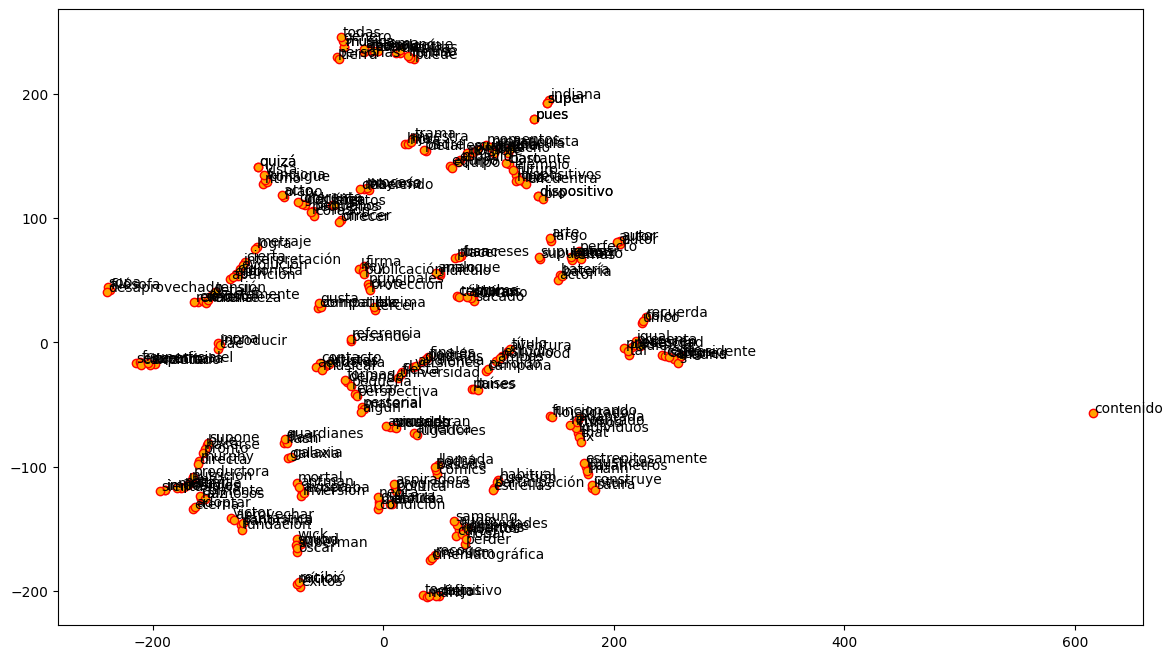

In [40]:
# Visualizamos
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Realizar consultas de palabras para ver el efectos de la similitud

Por ahora mostraré un par de ejemplos y más adelante con los otros modelos incluiré más ejemplos

In [41]:
# Con gensim encontramos las palabras más similares a determinado término, por ejemplo:
w2v_model.wv.most_similar("obra", topn=5)

[('arte', 0.9999536275863647),
 ('van', 0.9999517202377319),
 ('mano', 0.9999515414237976),
 ('encuentra', 0.9999503493309021),
 ('potente', 0.9999480247497559)]

In [42]:
# Para encontrar relaciones semánticas entre palabras:
w2v_model.wv.most_similar(positive=['libro', 'obra'], negative=['hombre'])

[('continuación', 0.9999189972877502),
 ('academia', 0.9999048113822937),
 ('david', 0.9998952150344849),
 ('castillo', 0.9998838901519775),
 ('león', 0.9998805522918701),
 ('episodio', 0.9998801350593567),
 ('versiones', 0.9998711347579956),
 ('cartel', 0.9998660087585449),
 ('sam', 0.9998558759689331),
 ('josé', 0.9998407363891602)]

## Guardar el modelo y volverlo a cargar

In [43]:
w2v_model.save("word2vec.model")

In [44]:
w2v_model = word2vec.Word2Vec.load("word2vec.model")


## Cargar un modelo preentrenado en español y usarlo para mejorar los *embeddings* del conjunto de datos seleccionado

* Realizar las mismas consultas de palabras para ver el efectos de la similitud con este nuevo modelo de embeddings y comparar con las consultas del modelo anterior.


In [45]:
pre_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Taller2/SBW-vectors-300-min5.bin.gz', binary=True) # Cargamos el modelo preentrenado

In [46]:
for word in w2v_model.wv.index_to_key:
  if word in pre_model:
    w2v_model.wv[word] = pre_model[word]

In [47]:
print("Modelo mejorado: ")
print(w2v_model.wv.most_similar("obra", topn=5)) # Modelo mejorado
print("Modelo pre-entrenado: ")
print(pre_model.most_similar("obra", topn=5)) # Modelo pre-entrenado

Modelo mejorado: 
[('seller', 46.64603805541992), ('coescrita', 46.301605224609375), ('diable', 44.66530990600586), ('expresivos', 38.368282318115234), ('bohemia', 37.597068786621094)]
Modelo pre-entrenado: 
[('obras', 0.7224675416946411), ('Propalladia', 0.6325260400772095), ('hernandiana', 0.6309537887573242), ('Lombía', 0.6253327131271362), ('Balderston', 0.6234709024429321)]


In [48]:
print("Modelo mejorado: ")
print(w2v_model.wv.most_similar("libro", topn=5)) # Modelo mejorado
print("Modelo pre-entrenado: ")
print(pre_model.most_similar("libro", topn=5)) # Modelo pre-entrenado

Modelo mejorado: 
[('seller', 80.1668472290039), ('books', 53.34888458251953), ('panfleto', 49.93709945678711), ('titulará', 47.94654846191406), ('narradas', 46.16328430175781)]
Modelo pre-entrenado: 
[('libros', 0.7001804709434509), ('poemario', 0.6999626755714417), ('novela', 0.6896499991416931), ('autobiografía', 0.6854430437088013), ('relato', 0.685041069984436)]


In [49]:
print("Modelo mejorado: ")
print(w2v_model.wv.most_similar(positive=['libro', 'obra'], negative=['hombre']))
print("Modelo pre-entrenado: ")
print(pre_model.most_similar(positive=['libro', 'obra'], negative=['hombre']))

Modelo mejorado: 
[('seller', 64.95645904541016), ('books', 45.28974151611328), ('coescrita', 43.6974983215332), ('editados', 43.64341354370117), ('titulará', 40.1610221862793), ('narradas', 38.82046890258789), ('panfleto', 37.695404052734375), ('épicos', 37.45005798339844), ('diable', 37.380577087402344), ('publicarla', 36.61497116088867)]
Modelo pre-entrenado: 
[('novela', 0.6111689209938049), ('biografía', 0.5991747379302979), ('Prólogos', 0.5774206519126892), ('antología', 0.5773420929908752), ('libros', 0.5729171633720398), ('Dublinés', 0.5593284368515015), ('prefacio', 0.5581492185592651), ('prólogo', 0.5569597482681274), ('poemario', 0.552184522151947), ('narrativa', 0.5492116808891296)]


Es bueno notar que los cambios no solo son entre el modelo mejorado y el pre-entrenado. Si vemos el modelo antes de ser mejorado daba otros resultados.

# 3.  FastText

*   Construir un modelo FastText para el conjunto de datos en español


In [54]:
ft_model = FastText(docs_tokens, vector_size=feature_size,
                  window=window_context, min_count=min_word_count,
                  epochs=25, workers=4,sg=1)

## Visualizar usando TSNE

In [55]:
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                 for search_term in palabras}

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

In [56]:
print(words)

['raíz', 'maíz', 'raícesy', 'melenaes', 'ghd', 'deslizan', 'filósofa', 'filósofo', 'filósofos', 'tombuctú', 'kairós', 'diadié', 'paz', 'paycheck', 'pazy', 'woo', 'serlonoche', 'noche', 'terminara', 'terminaré', 'terminar', 'terminaren', 'terminarían', 'terminará', 'panorama', 'diorama', 'panos', 'panorámico', 'panorámicos', 'panorámica', 'cursos', 'recursos', 'discursos', 'concursos', 'cursó', 'curso', 'that', 'pussycat', 'rimuru', 'mikami', 'slime', 'reincarnated', 'dos', 'msdos', 'dosmiles', 'recodos', 'entregas', 'dou', 'blue', 'beetle', 'beetleel', 'dcblue', 'beetleen', 'blueen', 'injusticias', 'injusticia', 'injustica', 'justiciasi', 'ajusticiar', 'justicia', 'retos', 'retosuno', 'retoscon', 'secretos', 'reto', 'nietos', 'sexo', 'sexos', 'sexosi', 'sex', 'sexy', 'sexys', 'música', 'músicas', 'músicamás', 'músicachenoa', 'músico', 'músicos', 'lanza', 'lanzas', 'lanzara', 'lanzan', 'lanzaba', 'lanzada', 'actuar', 'actua', 'actuado', 'actuarán', 'actualel', 'actual', 'franceses', 'fr

In [57]:
# Reducimos la dimensionalidad
tsne = TSNE(n_components=2, random_state=0, max_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

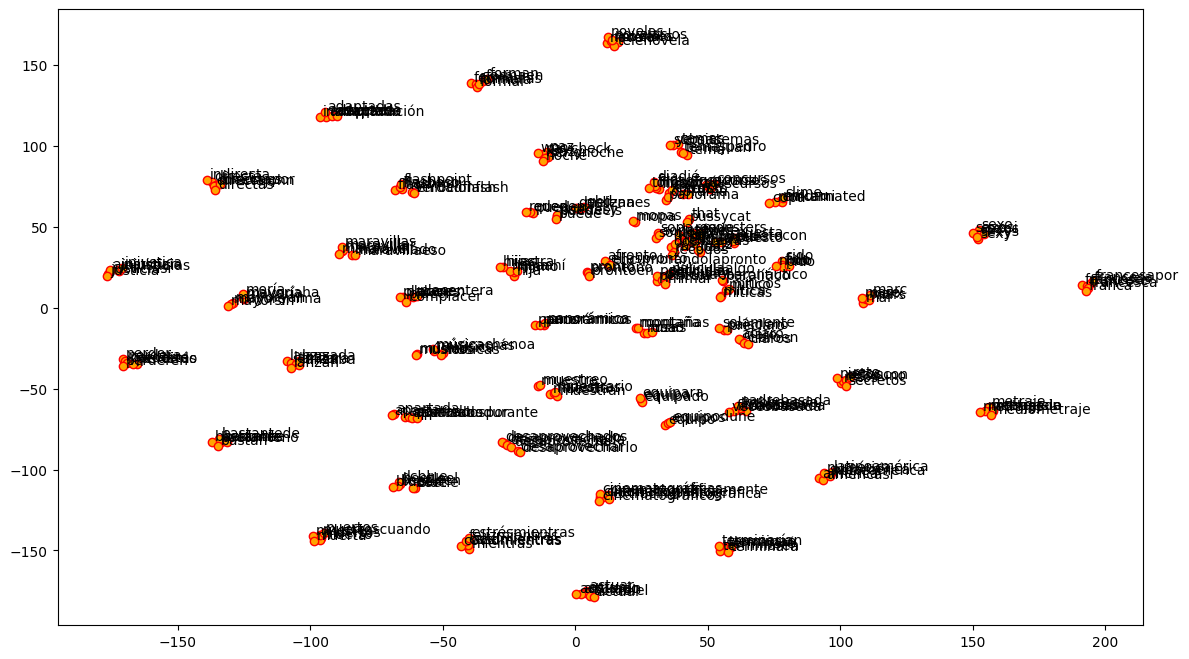

In [58]:
# Visualizamos
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')


##   Realizar consultas de palabras para ver el efectos de la similitud
*   Comparar con el modelo de word2vect

In [60]:
print("Modelo FastText: ")
print(ft_model.wv.most_similar("obra", topn=5)) # Modelo mejorado
print("Modelo mejorado w2v: ")
print(w2v_model.wv.most_similar("obra", topn=5)) # Modelo mejorado
print("Modelo pre-entrenado w2v: ")
print(pre_model.most_similar("obra", topn=5)) # Modelo pre-entrenado

Modelo FastText: 
[('obrar', 0.5136634707450867), ('obraen', 0.49040910601615906), ('maestra', 0.48333489894866943), ('obrado', 0.466111421585083), ('obras', 0.4603179097175598)]
Modelo mejorado w2v: 
[('seller', 46.64603805541992), ('coescrita', 46.301605224609375), ('diable', 44.66530990600586), ('expresivos', 38.368282318115234), ('bohemia', 37.597068786621094)]
Modelo pre-entrenado w2v: 
[('obras', 0.7224675416946411), ('Propalladia', 0.6325260400772095), ('hernandiana', 0.6309537887573242), ('Lombía', 0.6253327131271362), ('Balderston', 0.6234709024429321)]


In [61]:
print("Modelo FastText: ")
print(ft_model.wv.most_similar("libro", topn=5)) # Modelo mejorado
print("Modelo mejorado w2v: ")
print(w2v_model.wv.most_similar("libro", topn=5)) # Modelo mejorado
print("Modelo pre-entrenado w2v: ")
print(pre_model.most_similar("libro", topn=5)) # Modelo pre-entrenado

Modelo FastText: 
[('libroyo', 0.8272023797035217), ('libros', 0.7235814929008484), ('libroculpa', 0.6894626617431641), ('audiolibro', 0.6177753806114197), ('libra', 0.5850021839141846)]
Modelo mejorado w2v: 
[('seller', 80.1668472290039), ('books', 53.34888458251953), ('panfleto', 49.93709945678711), ('titulará', 47.94654846191406), ('narradas', 46.16328430175781)]
Modelo pre-entrenado w2v: 
[('libros', 0.7001804709434509), ('poemario', 0.6999626755714417), ('novela', 0.6896499991416931), ('autobiografía', 0.6854430437088013), ('relato', 0.685041069984436)]


In [62]:
print("Modelo FastText: ")
print(ft_model.wv.most_similar(positive=['libro', 'obra'], negative=['hombre']))
print("Modelo mejorado w2v: ")
print(w2v_model.wv.most_similar(positive=['libro', 'obra'], negative=['hombre']))
print("Modelo pre-entrenado w2v: ")
print(pre_model.most_similar(positive=['libro', 'obra'], negative=['hombre']))

Modelo FastText: 
[('libros', 0.5409713387489319), ('libroyo', 0.5191754102706909), ('libra', 0.47265639901161194), ('libroculpa', 0.4359190762042999), ('edhasalibros', 0.3984029293060303), ('libraba', 0.375666081905365), ('librado', 0.36368000507354736), ('bolsilibro', 0.3283916711807251), ('audiolibros', 0.32435116171836853), ('libérrimo', 0.31459590792655945)]
Modelo mejorado w2v: 
[('seller', 64.95645904541016), ('books', 45.28974151611328), ('coescrita', 43.6974983215332), ('editados', 43.64341354370117), ('titulará', 40.1610221862793), ('narradas', 38.82046890258789), ('panfleto', 37.695404052734375), ('épicos', 37.45005798339844), ('diable', 37.380577087402344), ('publicarla', 36.61497116088867)]
Modelo pre-entrenado w2v: 
[('novela', 0.6111689209938049), ('biografía', 0.5991747379302979), ('Prólogos', 0.5774206519126892), ('antología', 0.5773420929908752), ('libros', 0.5729171633720398), ('Dublinés', 0.5593284368515015), ('prefacio', 0.5581492185592651), ('prólogo', 0.556959748

# 4.  Doc2Vect
* Construir un modelo Doc2Vect para el conjunto de datos en español


In [64]:
tagged_corpus = [
        TaggedDocument(doc, [i])
        for i, doc in enumerate(docs_tokens)
        ]

In [65]:
display(tagged_corpus[0])

TaggedDocument(words=['valladolid', 'misteriosa', 'título', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador', 'paranormal', 'juan', 'carlos', 'pasalodos', 'pérez', 'realiza', 'exhaustiva', 'recopilación', 'gran', 'parte', 'enigmas', 'relatos', 'legendarios', 'vinculados', 'historia', 'valladolidy', 'capital', 'caracteriza', 'rica', 'historia', 'ende', 'abundancia', 'leyendas', 'arcanos', 'autor', 'recoge', 'volumen', 'junto', 'serie', 'casos', 'asombrosos', 'ocurridos', 'misma', 'urbe', 'provincia', 'relacionados', 'fenómenos', 'inexplicables', 'parecen', 'esquivos', 'comprensión', 'humanaasí', 'páginas', 'libro', 'podremos', 'encontrar', 'relatos', 'paranormal', 'coincidencias', 'inverosímiles', 'testimonios', 'sorprendentes', 'avistamientos', 'exorcismos', 'sucesos', 'desafían', 'toda', 'explicación', 'lógica', 'misterios', 'sábana', 'santa', 'vallisoletana', 'capilla', 'don', 'alonso', 'castillaen', 'definitiva', 'valladolid', 'misterio

In [66]:
display(tagged_corpus[1])

TaggedDocument(words=['coraje', 'ser', 'mónica', 'cavallé', 'aventura', 'autoconocimiento', 'filosóficotodos', 'experimentamos', 'momentos', 'plenitud', 'vinculados', 'expresión', 'directa', 'auténtica', 'mismos', 'momentos', 'contemplación', 'belleza', 'mundo', 'abren', 'si', 'vieran', 'primera', 'vez', 'intimidad', 'comunión', 'ser', 'humano', 'fluidez', 'creativa', 'expresión', 'confiada', 'libre', 'momentos', 'permiten', 'intuir', 'puede', 'ser', 'vida', 'meramente', 'existe', 'sino', 'vive', 'palabraesta', 'vida', 'solo', 'posible', 'sabemos', 'quiénes', 'conocemos', 'mismos', 'modo', 'experiencial', 'llenamos', 'ideas', 'sino', 'asentamos', 'ser', 'real', 'allá', 'defensas', 'máscaras', 'falsos', 'yoesel', 'coraje', 'ser', 'invitación', 'adentrarnos', 'forma', 'práctica', 'camino', 'autoconocimiento', 'sapiencial', 'ampliamente', 'vida', 'filosófica', 'busca', 'inspirar', 'acompañar', 'apasionante', 'aventura', 'desnudarnos', 'reconocer', 'vulnerabilidad', 'poder', 'vernos', 'ser

In [69]:
dc_model = Doc2Vec(
        documents = tagged_corpus,
        vector_size = 300,
        epochs = 20,
        workers = -1 # específica que se debe usar el número máximo de procesos.
        )

In [70]:
vect = dc_model.infer_vector(tagged_corpus[0].words)
display(vect)
display(vect.shape)

array([-0.0016267 ,  0.00080206, -0.00116383,  0.00050604,  0.00010734,
        0.00097285, -0.00106625, -0.00018148, -0.00145777,  0.00076775,
       -0.00148814, -0.00010282, -0.0010357 , -0.00066903, -0.00067189,
        0.00057102, -0.00062252, -0.00053371, -0.00101308, -0.00154067,
        0.00134634,  0.00005844, -0.0013794 , -0.00026883, -0.00133172,
        0.00093981,  0.00038038, -0.0008961 ,  0.00066268,  0.00105221,
        0.00048532, -0.00040602, -0.00139954, -0.00052085,  0.00076387,
       -0.00016298, -0.00117314,  0.00013834,  0.0003147 ,  0.00020822,
       -0.00056788,  0.00097298,  0.00166089,  0.00075355, -0.00008979,
        0.00163074,  0.00018868,  0.00154332, -0.00140062,  0.00011508,
        0.00130342,  0.00082515, -0.0011226 ,  0.00077655, -0.00109508,
        0.00061423,  0.00123265, -0.00073436,  0.00141056,  0.00092555,
       -0.0013496 , -0.00087403, -0.00039004,  0.00165901,  0.00100972,
       -0.00139916, -0.00020402,  0.00006864, -0.0008648 , -0.00

(300,)

## Realizar comparaciones entre los documentos usando similitud (usar los mismos 5 documentos seleccionados en el punto 1)
* Revisar los documentos originales y analizar el resultado obtenido usando la similitud.

In [116]:
cos_sim2 = [] # Guardamos los documentos junto con los valores de su cos

for i in range(len(tagged_corpus[0:100])): # Vamos a limitar un poco la cantidad de libros a los primeros 100 pues esa fue la cantidad que usamos para el punto 1
  for j in range(i+1,len(tagged_corpus[0:100])): # No guardamos consultas repetidas (0,1) = (1,0)
    if i == j:
      continue
    else:
      vec1 = dc_model.infer_vector(tagged_corpus[i].words)
      vec2 = dc_model.infer_vector(tagged_corpus[j].words)
      cos_sim2.append([i,j,cosine_similarity(vec1.reshape(1,-1), vec2.reshape(1,-1))])
      print("La similitud coseno entre el documento " + str(i) + " y el documento " + str(j) + " es " + str(cos_sim2[-1][-1]))

La similitud coseno entre el documento 0 y el documento 1 es [[-0.04883904]]
La similitud coseno entre el documento 0 y el documento 2 es [[-0.08617499]]
La similitud coseno entre el documento 0 y el documento 3 es [[0.05367527]]
La similitud coseno entre el documento 0 y el documento 4 es [[-0.02183303]]
La similitud coseno entre el documento 0 y el documento 5 es [[-0.01259935]]
La similitud coseno entre el documento 0 y el documento 6 es [[0.03457116]]
La similitud coseno entre el documento 0 y el documento 7 es [[0.07765147]]
La similitud coseno entre el documento 0 y el documento 8 es [[0.10437866]]
La similitud coseno entre el documento 0 y el documento 9 es [[-0.07464246]]
La similitud coseno entre el documento 0 y el documento 10 es [[0.03704445]]
La similitud coseno entre el documento 0 y el documento 11 es [[-0.03408952]]
La similitud coseno entre el documento 0 y el documento 12 es [[-0.06689428]]
La similitud coseno entre el documento 0 y el documento 13 es [[0.06971829]]
L

In [117]:
lista_ordenada2 = sorted(cos_sim2, key=lambda x: x[2], reverse=True) # Ordenamos la lista del mayor al menor valor de su cos

print("Los 5 documentos más cercanos entre si:")
for elemento in lista_ordenada2[0:5]:
    print("La similitud coseno entre el documento " + str(elemento[0]) + " y el documento " + str(elemento[1]) + " es " + str(elemento[2]))

Los 5 documentos más cercanos entre si:
La similitud coseno entre el documento 20 y el documento 73 es [[0.21654531]]
La similitud coseno entre el documento 90 y el documento 98 es [[0.19163565]]
La similitud coseno entre el documento 41 y el documento 58 es [[0.17636073]]
La similitud coseno entre el documento 13 y el documento 87 es [[0.17529608]]
La similitud coseno entre el documento 35 y el documento 38 es [[0.17490661]]


In [120]:
lista_ordenada2 = sorted(lista_ordenada2, key=lambda x: x[0]) # Ahora con la lista ordenada podemos volver a ordenar por libro y tomar los 5 vecinos más cercanos de los 5 primeros documentos (mismos del punto 1)

for i in range(5):
    print("Los 5 documentos más cercanos al documento " + str(i) + " son:")
    print("Modelo Doc2Vect: ")
    for elemento in lista_ordenada2[i*len(tagged_corpus[0:100])-(i):(i*len(tagged_corpus[0:100])-(i))+5]:
      print("El documento " + str(elemento[1]) + " tiene una similitud coseno de " + str(elemento[2]))
    print("Resultados primer punto: ")
    for elemento in lista_ordenada[i*len(norm_corpus)-(i):(i*len(norm_corpus)-(i))+5]:
      print("El documento " + str(elemento[1]) + " tiene una similitud coseno de " + str(elemento[2]))


Los 5 documentos más cercanos al documento 0 son:
Modelo Doc2Vect: 
El documento 25 tiene una similitud coseno de [[0.13116594]]
El documento 73 tiene una similitud coseno de [[0.11776777]]
El documento 68 tiene una similitud coseno de [[0.11403497]]
El documento 67 tiene una similitud coseno de [[0.10947142]]
El documento 32 tiene una similitud coseno de [[0.10831755]]
Resultados primer punto: 
El documento 53 tiene una similitud coseno de [0.05385366]
El documento 17 tiene una similitud coseno de [0.0490866]
El documento 19 tiene una similitud coseno de [0.04836259]
El documento 16 tiene una similitud coseno de [0.04627461]
El documento 70 tiene una similitud coseno de [0.03299589]
Los 5 documentos más cercanos al documento 1 son:
Modelo Doc2Vect: 
El documento 46 tiene una similitud coseno de [[0.12999642]]
El documento 84 tiene una similitud coseno de [[0.12560208]]
El documento 86 tiene una similitud coseno de [[0.12060306]]
El documento 52 tiene una similitud coseno de [[0.096195

Vamos ahora a relizar un pequeño análisis de los resultados comparando con el modelo TF-IDF del rpimer punto.

---

## 1. Diferencias en los modelos y su impacto en la similitud

Primero debemos aclarar algunas diferencias clave de los modelos para entender los resultados.

- **Doc2Vec**:
  - Representa cada documento como un vector denso en un espacio de menor dimensión, basado en contextos semánticos.
  - Utiliza técnicas de aprendizaje profundo para capturar significados más generales o abstractos.
  - Las similitudes reflejan relaciones semánticas, incluso si los términos específicos no coinciden directamente.

- **TF-IDF**:
  - Utiliza una matriz dispersa basada en la frecuencia de palabras y pondera cada término según su importancia relativa en el corpus.
  - Es más literal y sensible a la coincidencia de palabras específicas.
  - Puede no capturar relaciones semánticas profundas, especialmente cuando los documentos usan vocabulario diferente pero están relacionados temáticamente.

 Note que os valores de similitud en Doc2Vec tienden a ser más altos que en TF-IDF porque el espacio vectorial denso facilita encontrar relaciones más generales entre documentos, incluso si no comparten tantas palabras clave.

---

## 2. Similitudes comparadas

- **Doc2Vec**:
  - Los valores de similitud están consistentemente por encima de 0.1 en casi todos los casos.
  - Esto indica que los documentos identificados comparten contextos semánticos más profundos, aunque el valor en sí no sea muy alto.

- **TF-IDF**:
  - Los valores de similitud son notablemente más bajos (por debajo de 0.07 en la mayoría de los casos).
  - Esto sugiere que las palabras específicas usadas en los documentos relevantes tienen una coincidencia directa limitada.

### Ejemplo concreto:
- Para el documento 0:
  - **Doc2Vec** encuentra como más cercano al documento 25 (0.131), mientras que **TF-IDF** selecciona al documento 53 (0.053).
  - Esto sugiere que el documento 25 comparte un contexto semántico más general con el documento 0, mientras que el 53 probablemente tiene términos más específicos en común con el documento 0.

---

## 3. Interpretación de los resultados

- **Doc2Vec**: Útil para agrupar documentos por significado general o si los términos específicos no son cruciales para el análisis.
- **TF-IDF**: Preferible para identificar documentos con palabras clave específicas y enfoques más literales.

### Diferencias de magnitud:
La diferencia en los valores de similitud (e.g., 0.1 en Doc2Vec frente a 0.05 en TF-IDF) es normal debido a las características de los espacios vectoriales que utilizan:
- Los vectores densos de Doc2Vec tienden a concentrar relaciones más generales.
- La matriz dispersa de TF-IDF refleja relaciones más "estrechas".

---
